<a href="https://colab.research.google.com/github/vanshpreet5618/Sleep-Stage-Classification/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SLEEP STAGE CLASSIFICATION

MNE-Python is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data such as MEG, EEG, sEEG, ECoG, and more. It includes modules for data input/output, preprocessing, visualization, source estimation, time-frequency analysis, connectivity analysis, machine learning, statistics, and more.

In [ ]:
!pip install mne


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import LeaveOneGroupOut

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [ ]:
# Experiment variables

# classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1/2/3/4": 2,
    "Sleep stage R": 3,
}

# Frequency bands range in Hz for EEG
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Number of participants used in the analysis
NUM_PARTICIPANT = 20

DATA COLLECTION AND PRE PROCESSING


In [ ]:
def load_data(participant_id, event_id=EVENT_ID):

  ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 2,
    "Sleep stage 3": 2,
    "Sleep stage 4": 2,
    "Sleep stage R": 3,
  }


  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])


  raw_edf = mne.io.read_raw_edf(
    participant_file[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
  )


  annotation_edf = mne.read_annotations(participant_file[1])

  # keep last 4h wake events before sleep and first 4h wake events after
  # sleep and redefine annotations on raw data
  annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 240, annotation_edf[-2]["onset"] + 30 * 240)

  # Attach the annotation file to the raw edf loaded
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  # Chunk the data into 30 seconds epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
  )



  tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]

  epochs = mne.Epochs(
      raw=raw_edf,
      events=events,
      event_id=event_id,
      tmin=0.0,
      tmax=tmax,
      baseline=None,
      preload=True,
  )

  return raw_edf, events, epochs


all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
  _, _, epochs = load_data(participant_id=participant_id)
  all_participant_epochs.append(epochs)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1201 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1463 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1463 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setti

In [ ]:
all_participant_epochs


[<Epochs | 1201 events (all good), 0 – 29.99 s (baseline off), ~192.4 MiB, data loaded,
  'Sleep stage W': 548
  'Sleep stage 1/2/3/4': 528
  'Sleep stage R': 125>,
 <Epochs | 1463 events (all good), 0 – 29.99 s (baseline off), ~234.4 MiB, data loaded,
  'Sleep stage W': 517
  'Sleep stage 1/2/3/4': 776
  'Sleep stage R': 170>,
 <Epochs | 1385 events (all good), 0 – 29.99 s (baseline off), ~221.9 MiB, data loaded,
  'Sleep stage W': 488
  'Sleep stage 1/2/3/4': 734
  'Sleep stage R': 163>,
 <Epochs | 1312 events (all good), 0 – 29.99 s (baseline off), ~210.2 MiB, data loaded,
  'Sleep stage W': 500
  'Sleep stage 1/2/3/4': 603
  'Sleep stage R': 209>,
 <Epochs | 1595 events (all good), 0 – 29.99 s (baseline off), ~255.6 MiB, data loaded,
  'Sleep stage W': 560
  'Sleep stage 1/2/3/4': 839
  'Sleep stage R': 196>,
 <Epochs | 1032 events (all good), 0 – 29.99 s (baseline off), ~165.4 MiB, data loaded,
  'Sleep stage W': 568
  'Sleep stage 1/2/3/4': 396
  'Sleep stage R': 68>,
 <Epochs | 

feature extraction


In [ ]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):


  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)


  # (epoch, number of channels (we have two), frequency_bins)
  # We'll slice and average to get the delta to theta bands (5 feature per channel)
  # Therefore we should finish with (epoch, number of channels * number of bands)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)

In [ ]:


X = []
y = []
groups = []
for group_id, epochs in enumerate(all_participant_epochs):
  print(f"Processing participants #{group_id}")

  X_epoch = eeg_power_band(epochs)
  y_epoch = epochs.events[:, 2]
  group_epoch = [group_id]*len(y_epoch)

  X.append(X_epoch)
  y.append(y_epoch)
  groups.append(group_epoch)

# Transform these lists into numpy array with proper size for sklearn models
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
groups = np.concatenate(groups, axis=0)

Processing participants #0
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #1
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #2
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #3
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #4
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #5
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #6
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #7
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #8
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #9
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #10
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #11
   

RANDOM FOREST WITH STRATIFIED K fold

Fold 1
Accuracy: 0.9117
              precision    recall  f1-score   support

           1       0.93      0.96      0.95      2229
           2       0.93      0.91      0.92      2685
           3       0.77      0.78      0.78       751

    accuracy                           0.91      5665
   macro avg       0.88      0.88      0.88      5665
weighted avg       0.91      0.91      0.91      5665

------------------------------
Fold 2
Accuracy: 0.9057
              precision    recall  f1-score   support

           1       0.93      0.95      0.94      2229
           2       0.93      0.90      0.91      2684
           3       0.75      0.80      0.77       752

    accuracy                           0.91      5665
   macro avg       0.87      0.88      0.88      5665
weighted avg       0.91      0.91      0.91      5665

------------------------------
Fold 3
Accuracy: 0.9084
              precision    recall  f1-score   support

           1       0.93      0.96      0.94      

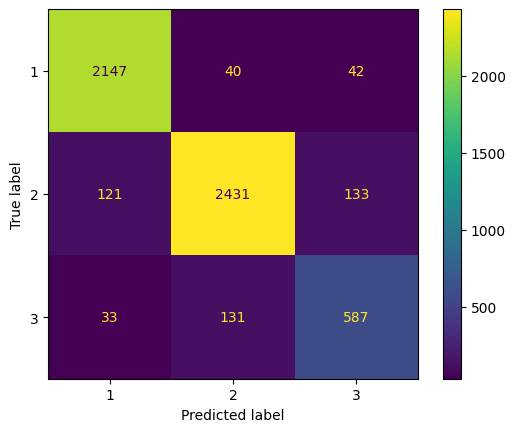

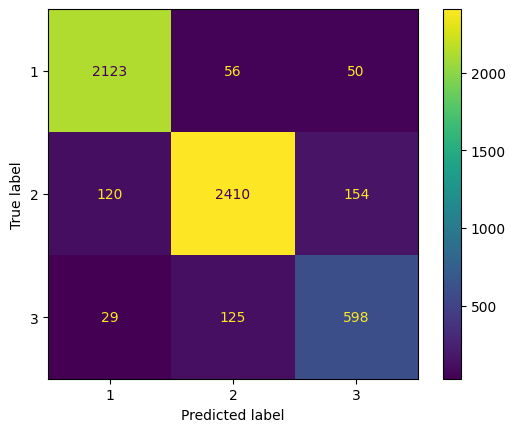

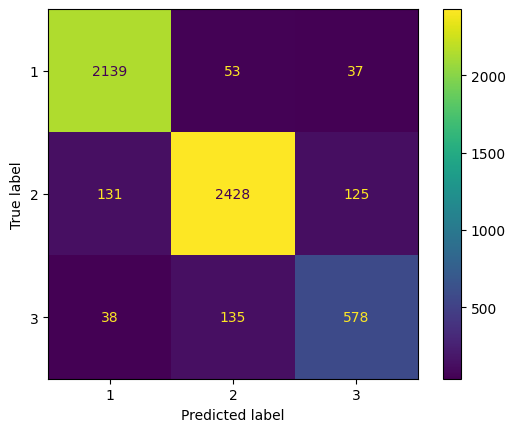

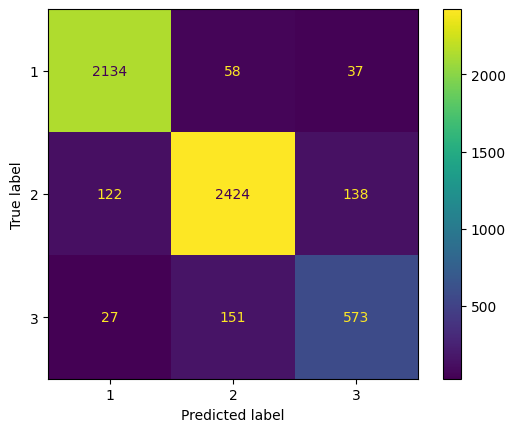

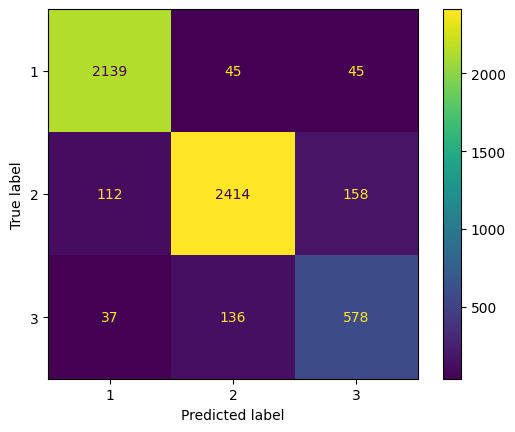

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# To store the results
accuracies = []
all_classification_reports = []
all_confusion_matrices = []
for fold, (train, test) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")


    model = RandomForestClassifier(n_estimators=100, random_state=42)
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    print(classification_report(y_test, y_pred))
    print("-" * 30)
    # Print average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")


Fold 1
Accuracy: 0.8718
Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.91      0.93      2229
           2       0.86      0.90      0.88      2685
           3       0.72      0.64      0.68       751

    accuracy                           0.87      5665
   macro avg       0.84      0.82      0.83      5665
weighted avg       0.87      0.87      0.87      5665

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      2229
           2       0.86      0.90      0.88      2685
           3       0.72      0.64      0.68       751

    accuracy                           0.87      5665
   macro avg       0.84      0.82      0.83      5665
weighted avg       0.87      0.87      0.87      5665

------------------------------
Fold 2
Accuracy: 0.8643
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      2229
    

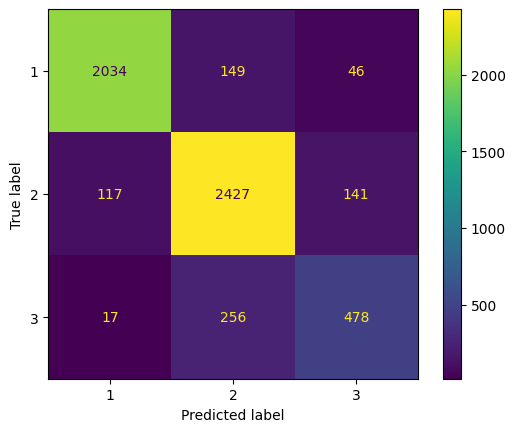

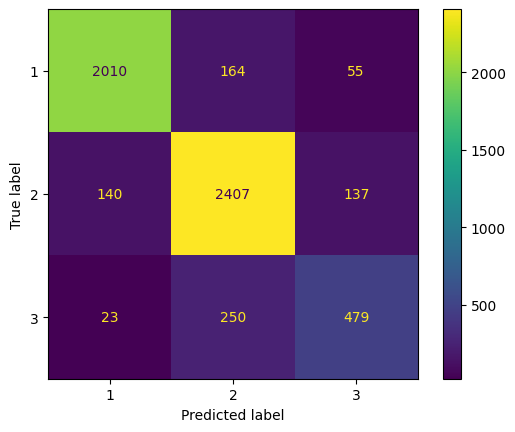

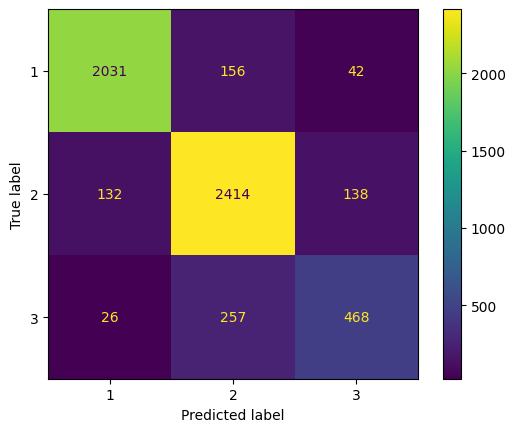

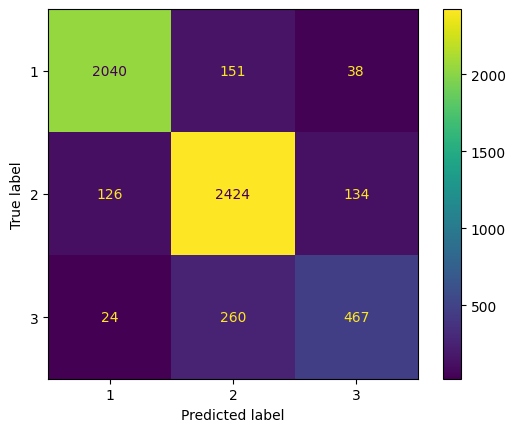

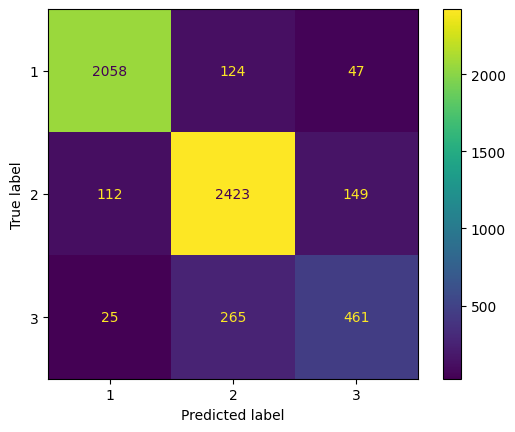

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store the results
accuracies = []
all_classification_reports = []
all_confusion_matrices = []

# Iterate over Stratified K-Folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize and train the SVM model
    model = SVC(kernel='rbf', random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Save classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    all_classification_reports.append(report)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    print(classification_report(y_test, y_pred))
    print("-" * 30)

# Print average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")


Fold 1
Accuracy: 0.8831
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93      2229
           2       0.90      0.89      0.89      2685
           3       0.71      0.69      0.70       751

    accuracy                           0.88      5665
   macro avg       0.84      0.84      0.84      5665
weighted avg       0.88      0.88      0.88      5665

------------------------------
Fold 2
Accuracy: 0.8791
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.93      0.93      2229
           2       0.90      0.88      0.89      2684
           3       0.70      0.70      0.70       752

    accuracy                           0.88      5665
   macro avg       0.84      0.84      0.84      5665
weighted avg       0.88      0.88      0.88      5665

------------------------------
Fold 3
Accuracy: 0.8881
Classification Report:
              precision    recall  

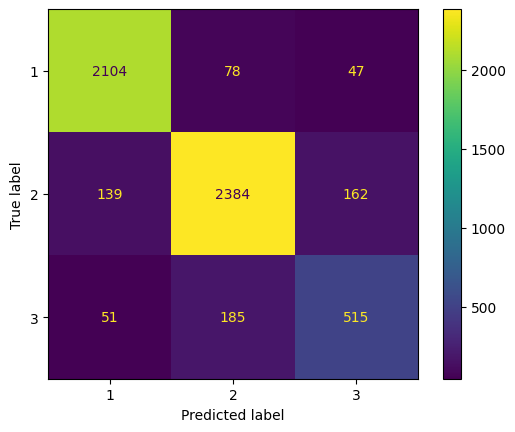

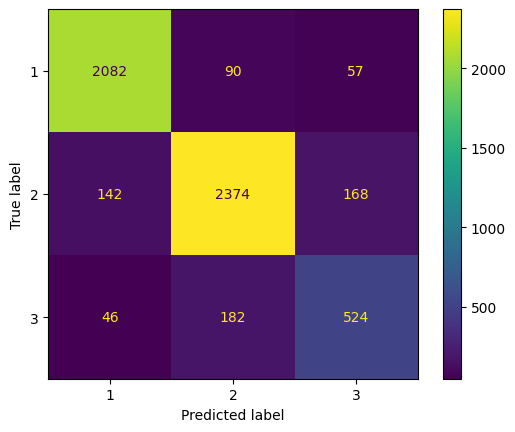

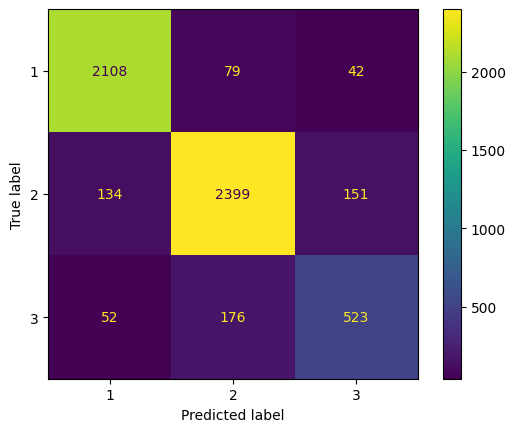

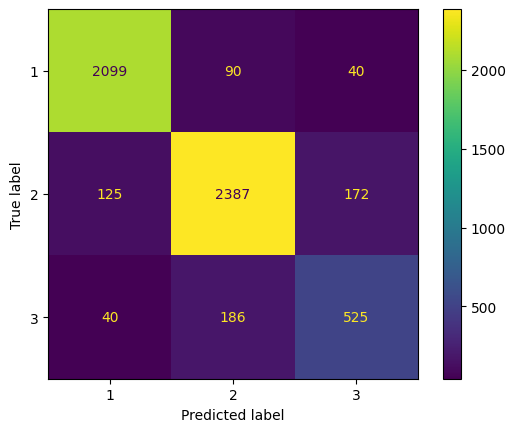

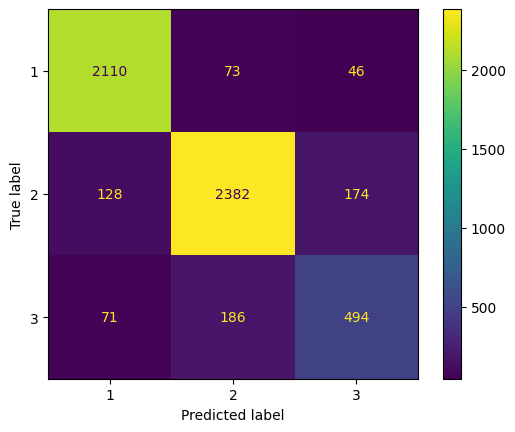

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store the results
accuracies = []
all_classification_reports = []
all_confusion_matrices = []

# Iterate over Stratified K-Folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize and train the KNN model
    model = KNeighborsClassifier(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Save classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    all_classification_reports.append(report)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    print("-" * 30)

# Print average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")


In [ ]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):
  """Calculate relative spectral analysis on the EEG sensors for each epochs"""

  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)

  # shape of PSDS:
  # (epoch, number of channels (we have two), frequency_bins)
  # We'll slice and average to get the delta to theta bands (5 feature per channel)
  # Therefore we should finish with (epoch, number of channels * number of bands)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)


In [ ]:
# Map sleep stages to higher-level categories
CATEGORY_MAPPING = {
    "Awake": ["Sleep stage W"],
    "Sleeping": ["Sleep stage 1/2/3/4", "Sleep stage R"]
}

# Calculate random guess probabilities for `Awake` and `Sleeping`
random_guess_train = {}
total_epochs = sum(len(epochs_train[stage]) for stage in epochs_train.keys())

for category, stages_in_category in CATEGORY_MAPPING.items():
    category_count = sum(len(epochs_train[stage]) for stage in stages_in_category)
    random_guess_train[category] = category_count / total_epochs

print("Random guess for the training participant: ")
print(random_guess_train)


Random guess for the training participant: 
{'Awake': 0.4562864279766861, 'Sleeping': 0.5437135720233139}


Testing on participant: #0
Accuracy score: 0.8792672772689425
                     precision    recall  f1-score   support

      Sleep stage W       1.00      0.86      0.92       548
Sleep stage 1/2/3/4       0.86      0.92      0.89       528
      Sleep stage R       0.60      0.78      0.67       125

           accuracy                           0.88      1201
          macro avg       0.82      0.85      0.83      1201
       weighted avg       0.90      0.88      0.88      1201

{'Sleep stage W': 1, 'Sleep stage 1/2/3/4': 2, 'Sleep stage R': 3}
Testing on participant: #1
Accuracy score: 0.885850991114149
                     precision    recall  f1-score   support

      Sleep stage W       0.85      0.99      0.92       517
Sleep stage 1/2/3/4       0.96      0.83      0.89       776
      Sleep stage R       0.74      0.82      0.78       170

           accuracy                           0.89      1463
          macro avg       0.85      0.88      0.86      1463
       weigh

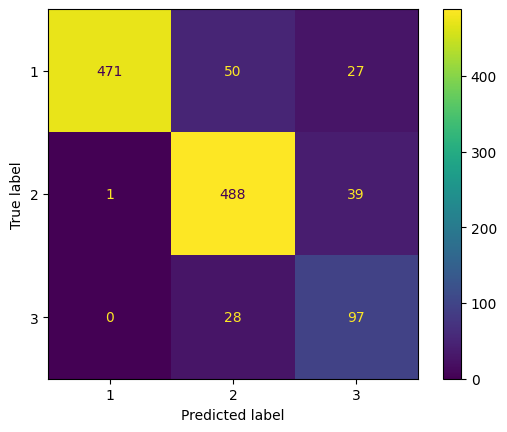

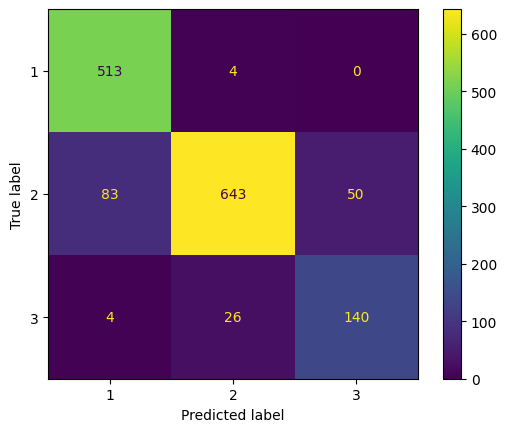

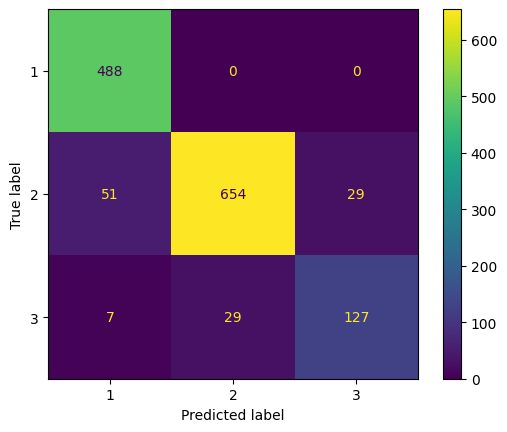

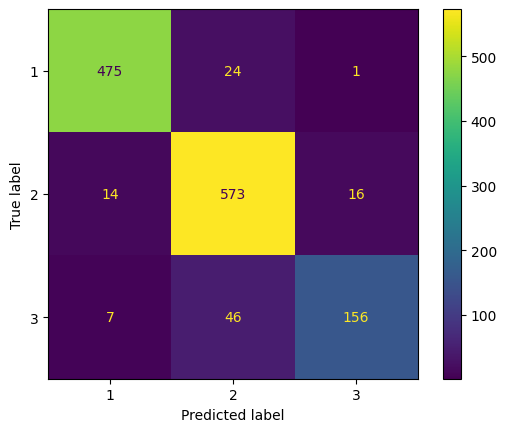

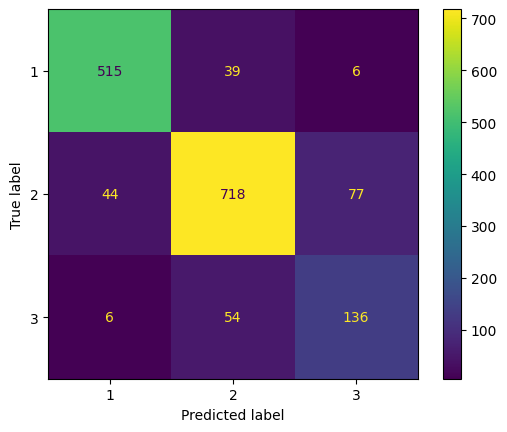

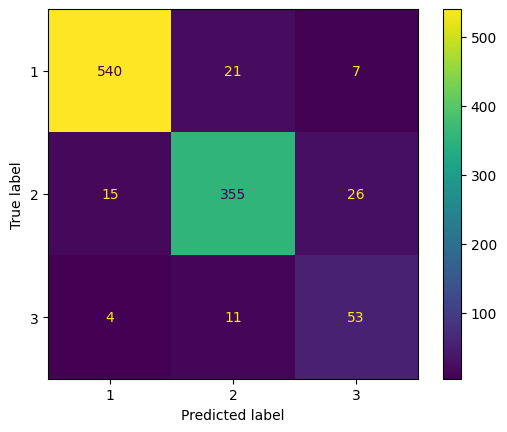

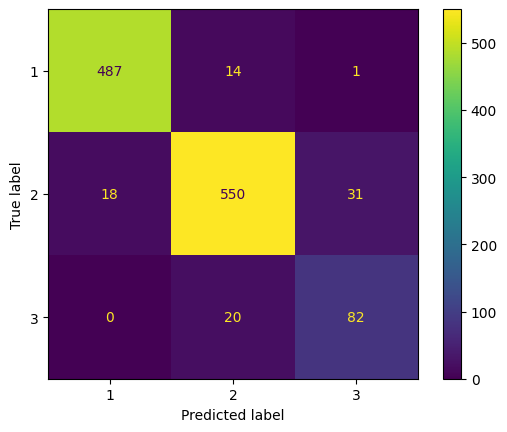

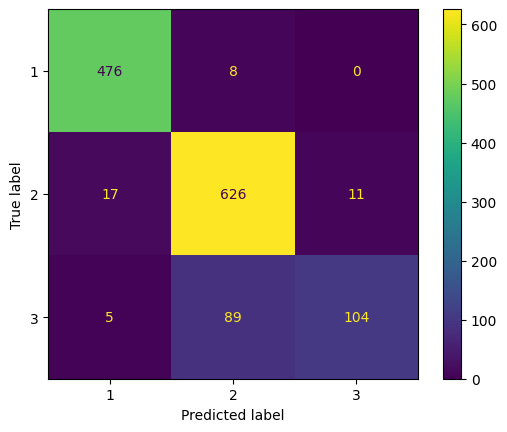

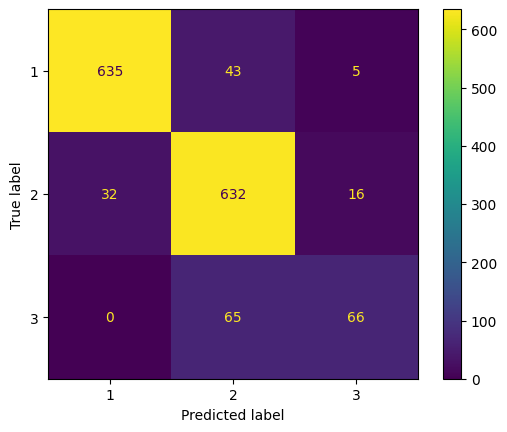

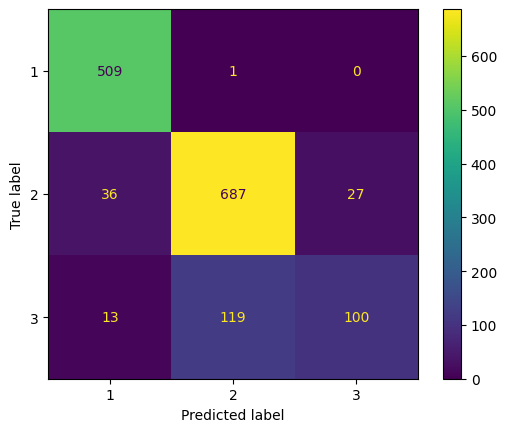

In [ ]:
# Leave One Participant Out Cross Validation, using group_id == participant_id
logo = LeaveOneGroupOut()

group_id = 0
for train, test in logo.split(X, y, groups=groups):
  print(f"Testing on participant: #{group_id}")
  group_id = group_id + 1

  # Training of the classifier
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  X_train = X[train]
  y_train = y[train]
  model.fit(X_train, y_train)

  # Testing using the current participant data left out
  X_test = X[test]
  y_test = y[test]
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)

  print(f"Accuracy score: {acc}")

  # Create a confusion matrix and a report on all the metrics
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot() # will appear at the end of the output

  print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
  print(EVENT_ID)


Fold 1
Accuracy: 0.8878
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.96      0.94       558
           2       0.91      0.89      0.90       671
           3       0.71      0.69      0.70       188

    accuracy                           0.89      1417
   macro avg       0.85      0.84      0.85      1417
weighted avg       0.89      0.89      0.89      1417

------------------------------
Fold 2
Accuracy: 0.8687
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92       558
           2       0.91      0.87      0.89       671
           3       0.65      0.66      0.66       188

    accuracy                           0.87      1417
   macro avg       0.82      0.82      0.82      1417
weighted avg       0.87      0.87      0.87      1417

------------------------------
Fold 3
Accuracy: 0.8849
Classification Report:
              precision    recall  

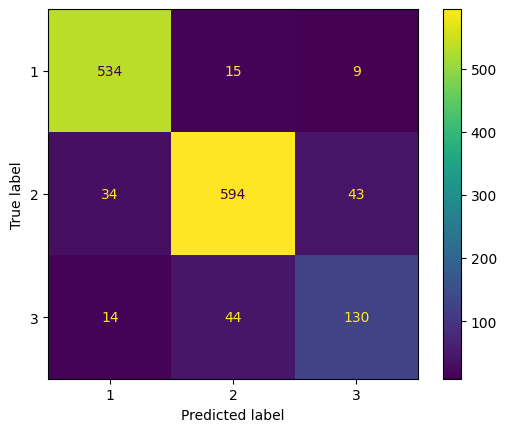

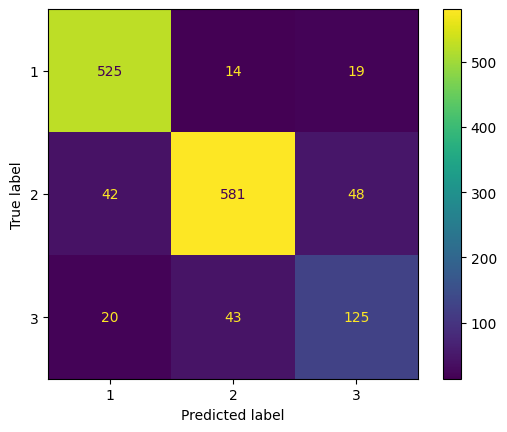

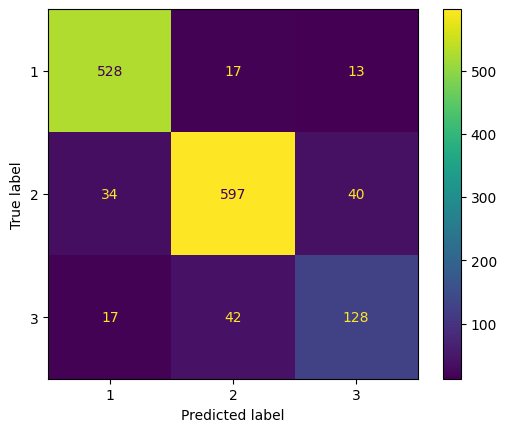

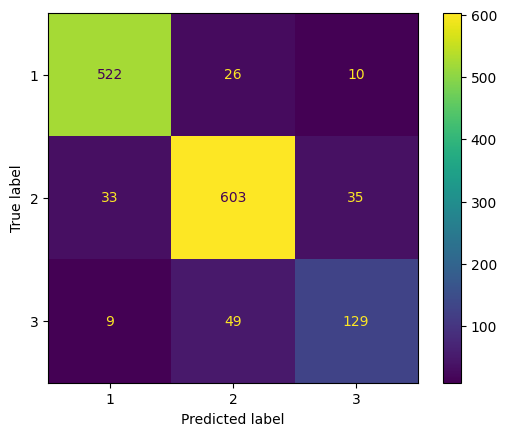

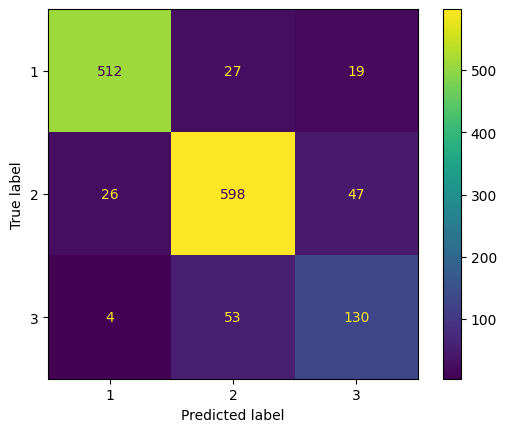

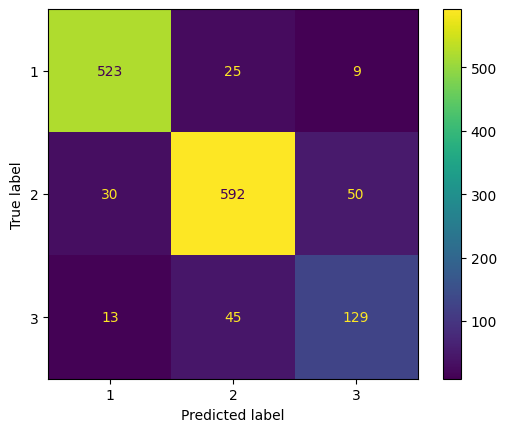

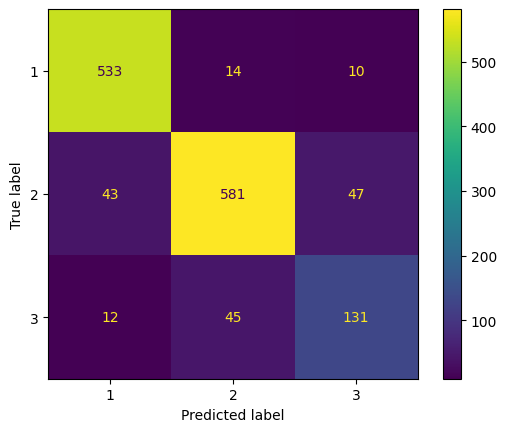

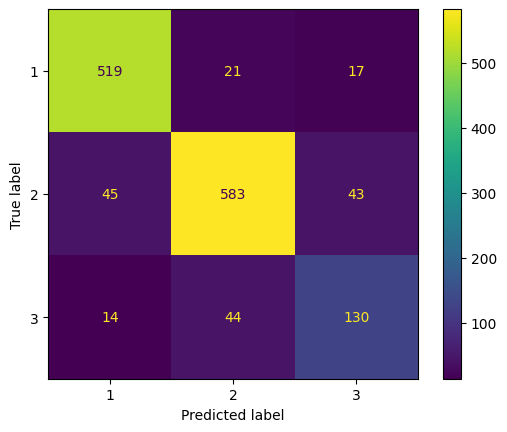

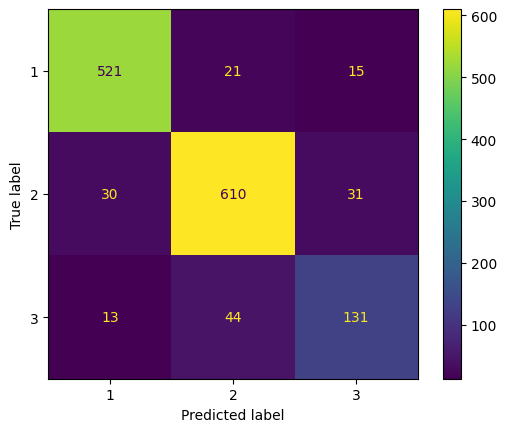

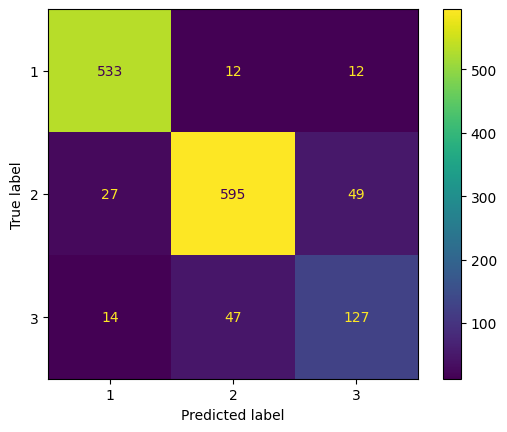

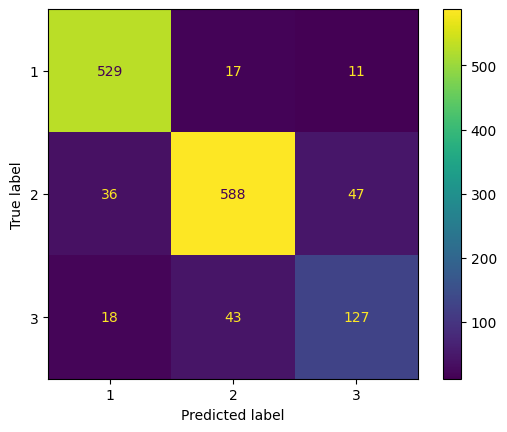

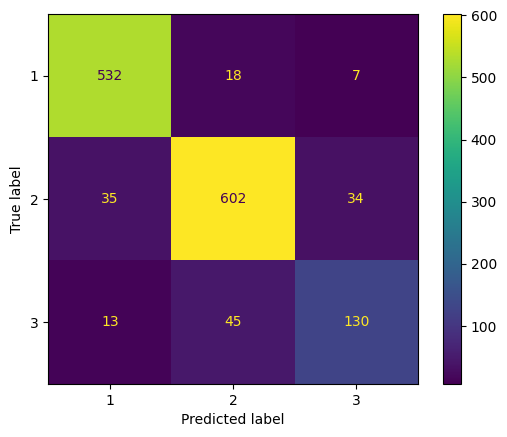

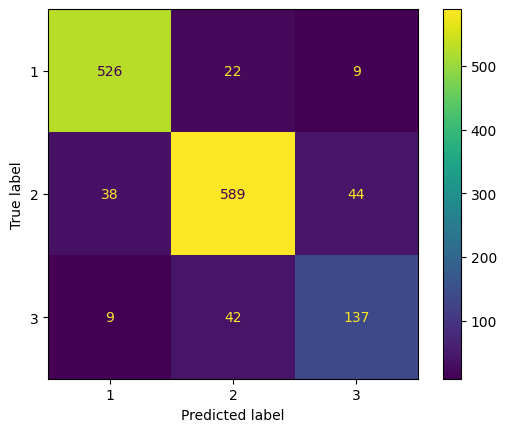

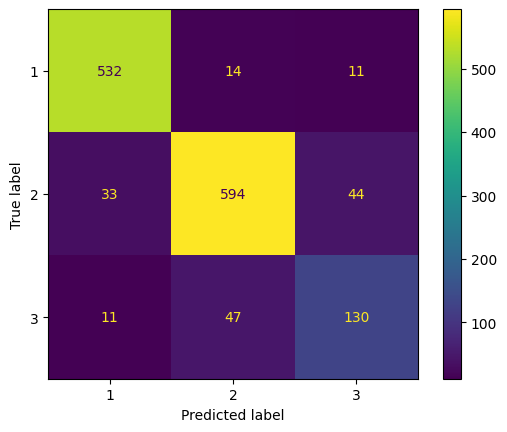

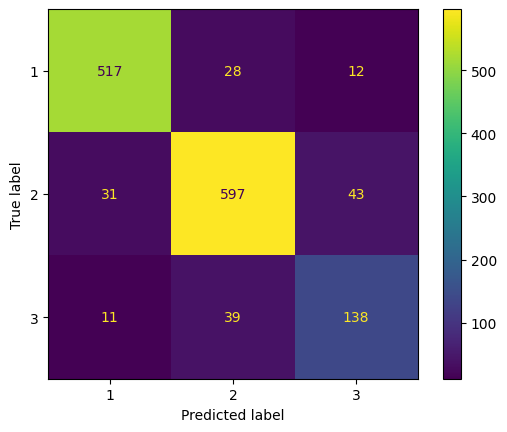

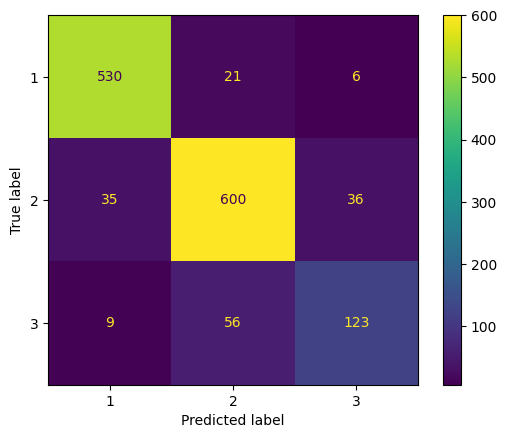

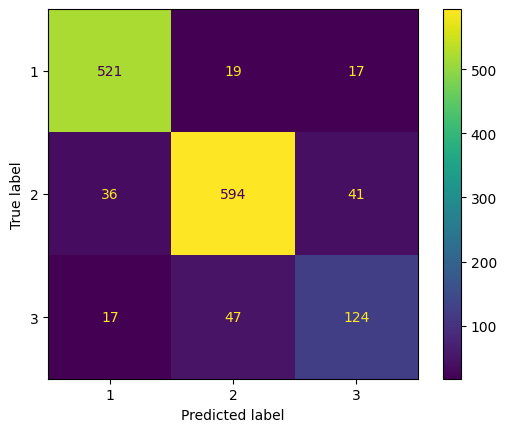

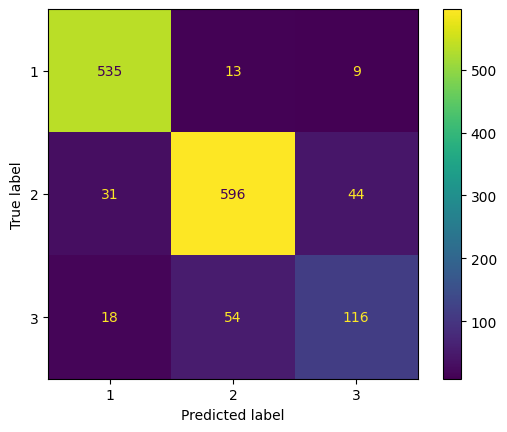

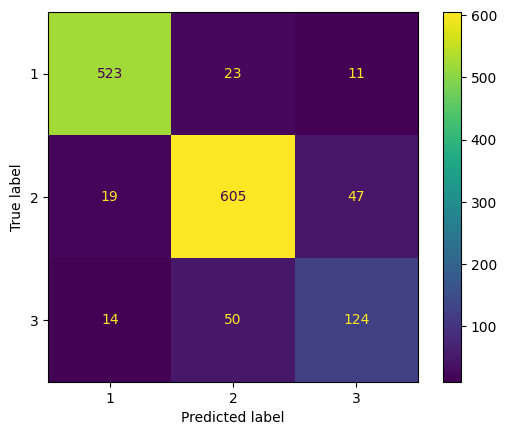

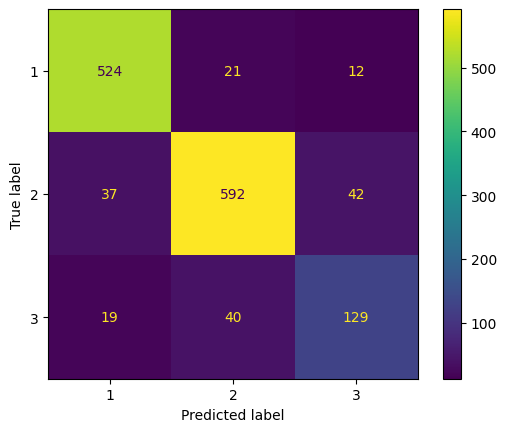

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

# To store the results
accuracies = []
all_classification_reports = []
all_confusion_matrices = []

# Iterate over Stratified K-Folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize and train the KNN model
    model = KNeighborsClassifier(n_neighbors=5)  # You can adjust 'n_neighbors' as needed
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Save classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    all_classification_reports.append(report)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    print("-" * 30)

# Print average accuracy across all folds
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")


Fold 1
Accuracy: 0.8180
Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.82      0.87      2229
           2       0.83      0.84      0.83      2685
           3       0.57      0.74      0.65       751

    accuracy                           0.82      5665
   macro avg       0.78      0.80      0.78      5665
weighted avg       0.83      0.82      0.82      5665

------------------------------
Fold 2
Accuracy: 0.8180
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.82      0.87      2229
           2       0.83      0.84      0.83      2684
           3       0.58      0.74      0.65       752

    accuracy                           0.82      5665
   macro avg       0.78      0.80      0.78      5665
weighted avg       0.83      0.82      0.82      5665

------------------------------
Fold 3
Accuracy: 0.8144
Classification Report:
              precision    recall  

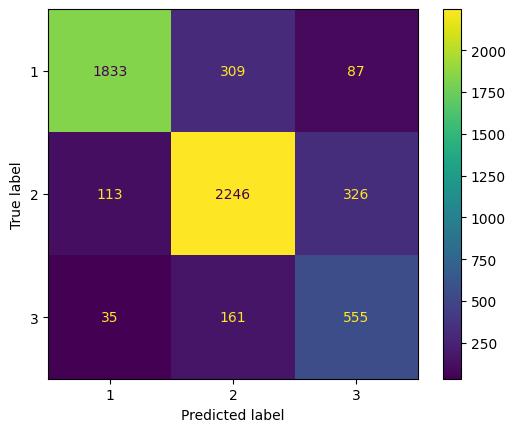

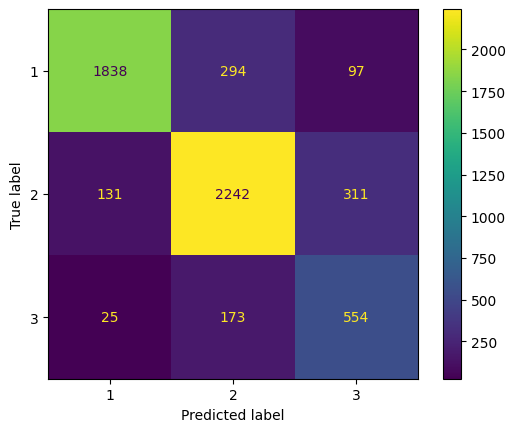

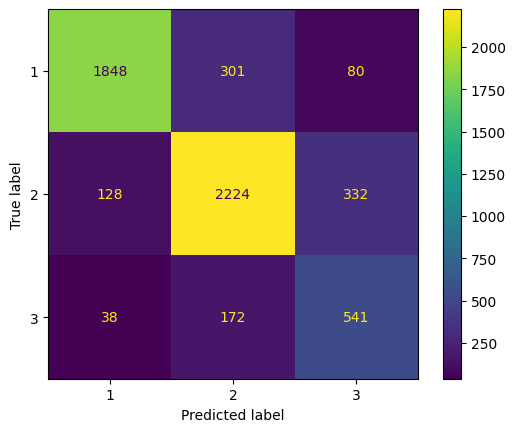

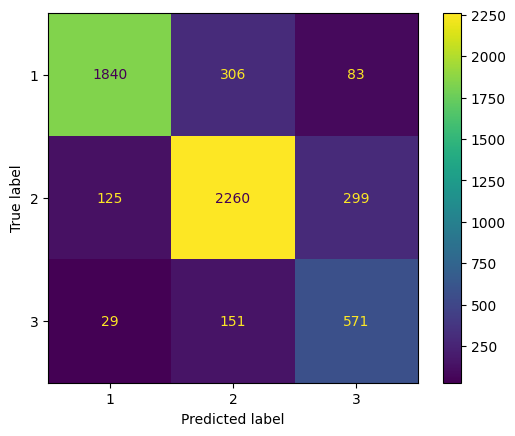

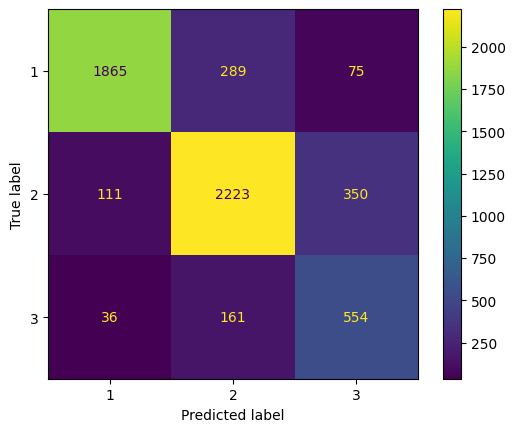

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming X (features) and y (labels) are defined
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store the results
accuracies = []
all_classification_reports = []
all_confusion_matrices = []

# Iterate over Stratified K-Folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    # Split the data into training and testing sets
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Initialize and train the Bayesian Network model
    model = GaussianNB()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")

    # Save classification report and confusion matrix
    report = classification_report(y_test, y_pred, output_dict=True)
    all_classification_reports.append(report)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    print("-" * 30)

# Print average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")


Evaluating SVM
Evaluating Random Forest
Evaluating KNN
Evaluating Bayesian Network


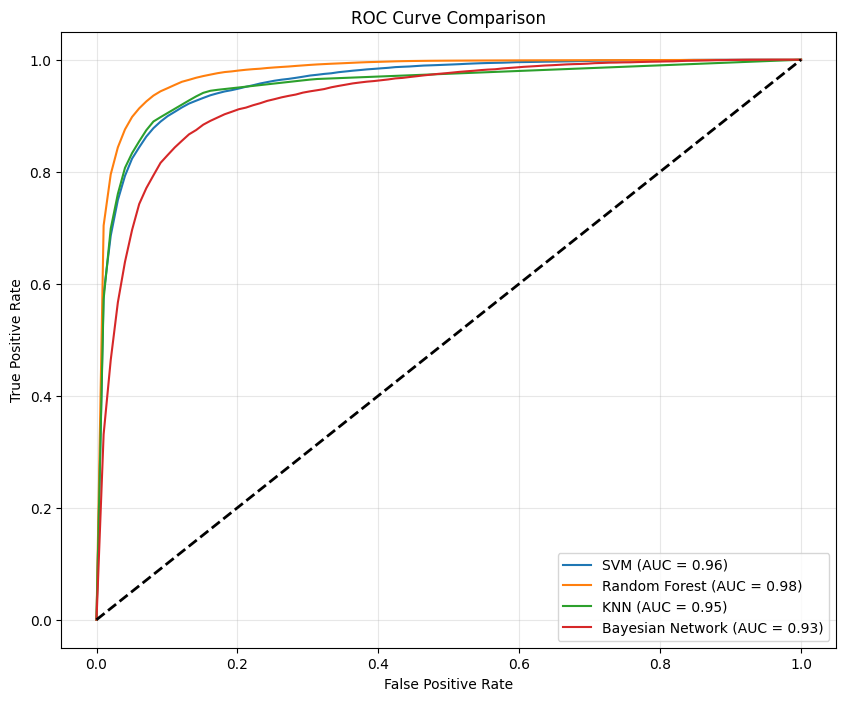

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming X (features) and y (labels) are defined
n_classes = len(np.unique(y))
y_binarized = label_binarize(y, classes=np.unique(y))  # Binarize labels for ROC

# Models to evaluate
models = {
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bayesian Network": GaussianNB()
}

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# To store ROC data
roc_data = {model_name: {"fpr": [], "tpr": [], "auc": []} for model_name in models}

# Iterate over models
for model_name, model in models.items():
    print(f"Evaluating {model_name}")
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []

    for train_idx, test_idx in skf.split(X, y):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Predict probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        else:  # For SVM use decision_function
            y_score = model.decision_function(X_test)

        # Compute ROC curve and AUC for each class
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_binarized[test_idx][:, i], y_score[:, i])
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc(fpr, tpr))

    # Average across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Store results
    roc_data[model_name]["fpr"] = mean_fpr
    roc_data[model_name]["tpr"] = mean_tpr
    roc_data[model_name]["auc"] = mean_auc

# Plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, data in roc_data.items():
    plt.plot(data["fpr"], data["tpr"],
             label=f'{model_name} (AUC = {data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
